In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [99]:
import pandas as pd
import quandl
import datetime
start = datetime.datetime(2006,1,1)
end = datetime.date.today()
amz = quandl.get("WIKI/AMZN", start_date=start, end_date=end)

In [106]:
amz.shape

(3077, 12)

In [21]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Amazon Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Amazon Stock Price')
    plt.title('Amazon Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Amazon Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [102]:
dataset = pd.read_csv('AMZN_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN


In [104]:
dataset.shape

(3019, 6)

In [8]:
training_set = dataset[:'2016'].iloc[:,1:2].values
test_set = dataset['2017':].iloc[:,1:2].values

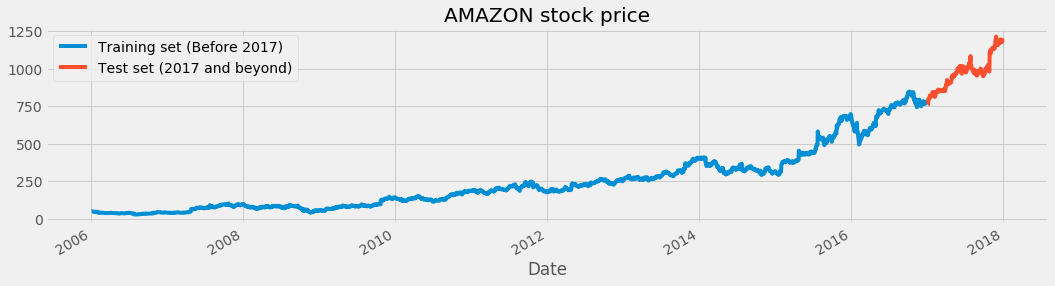

In [10]:
#We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('AMAZON stock price')
plt.show()


In [11]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output. So for each element of training set, we have 60 previous training set elements 

In [ ]:
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [16]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [29]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

Epoch 1/5
2708/2708 [==============================] - 16s 6ms/step - loss: 0.0107
Epoch 2/5
2708/2708 [==============================] - 13s 5ms/step - loss: 0.0045
Epoch 3/5
2708/2708 [==============================] - 13s 5ms/step - loss: 0.0036
Epoch 4/5
2708/2708 [==============================] - 13s 5ms/step - loss: 0.0030
Epoch 5/5
2708/2708 [==============================] - 13s 5ms/step - loss: 0.0025


Now to get the test set ready in a similar way as the training set.The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
'High' attribute data for processing

In [30]:
dataset_total = pd.concat((dataset["High"][:'2016'],dataset["High"]['2017':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [31]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

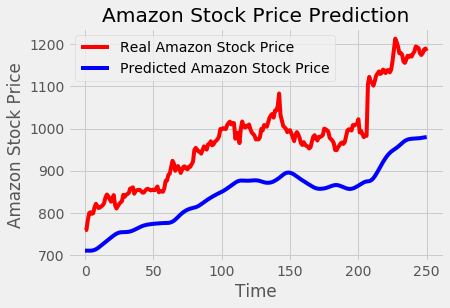

In [32]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [24]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 134.9467274015809.


In [26]:
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=5,batch_size=150)

Epoch 1/5
2708/2708 [==============================] - 6s 2ms/step - loss: 0.0588
Epoch 2/5
2708/2708 [==============================] - 4s 2ms/step - loss: 0.0194
Epoch 3/5
2708/2708 [==============================] - 4s 2ms/step - loss: 0.0031
Epoch 4/5
2708/2708 [==============================] - 4s 2ms/step - loss: 0.0027
Epoch 5/5
2708/2708 [==============================] - 4s 2ms/step - loss: 0.0021


In [27]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

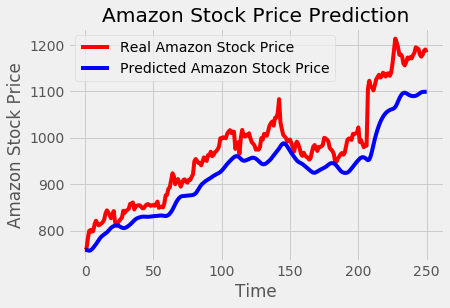

In [28]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [37]:
# The LSTM architecture
regressorLG = Sequential()
# First LSTM layer with Dropout regularisation
regressorLG.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLG.add(Dropout(0.2))
regressorLG.add(GRU(units=50, activation='tanh'))
regressorLG.add(Dropout(0.2))
# The output layer
regressorLG.add(Dense(units=1))
# Compiling the RNN
regressorLG.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorLG.fit(X_train,y_train,epochs=5,batch_size=150)

Epoch 1/5
2708/2708 [==============================] - 4s 1ms/step - loss: 0.0640
Epoch 2/5
2708/2708 [==============================] - 2s 745us/step - loss: 0.0205
Epoch 3/5
2708/2708 [==============================] - 2s 720us/step - loss: 0.0052
Epoch 4/5
2708/2708 [==============================] - 2s 726us/step - loss: 0.0023
Epoch 5/5
2708/2708 [==============================] - 2s 800us/step - loss: 0.0020


In [38]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LG_predicted_stock_price = regressorLG.predict(X_test)
LG_predicted_stock_price = sc.inverse_transform(LG_predicted_stock_price)

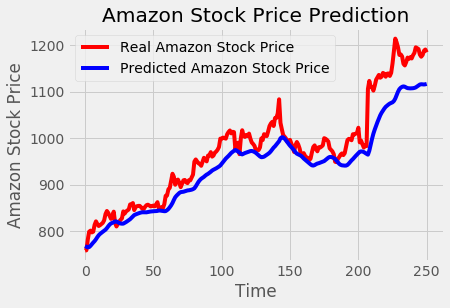

In [39]:
# Visualizing the results for GRU
plot_predictions(test_set,LG_predicted_stock_price)

In [43]:
X_train

array([[[0.02625136],
        [0.02610518],
        [0.02667771],
        ...,
        [0.01140198],
        [0.01184052],
        [0.01280287]],

       [[0.02610518],
        [0.02667771],
        [0.02714061],
        ...,
        [0.01184052],
        [0.01280287],
        [0.0129125 ]],

       [[0.02667771],
        [0.02714061],
        [0.02533773],
        ...,
        [0.01280287],
        [0.0129125 ],
        [0.01275414]],

       ...,

       [[0.99104652],
        [0.99409192],
        [0.99812403],
        ...,
        [0.90741981],
        [0.90168228],
        [0.91161029]],

       [[0.99409192],
        [0.99812403],
        [1.        ],
        ...,
        [0.90168228],
        [0.91161029],
        [0.91812744]],

       [[0.99812403],
        [1.        ],
        [0.99846512],
        ...,
        [0.91161029],
        [0.91812744],
        [0.91008759]]])

In [91]:
import pandas as pd
import quandl
import datetime
start = datetime.datetime(2018,1,1)
end = datetime.date.today()
amz = quandl.get("WIKI/AMZN", start_date=start, end_date=end)


In [92]:
amz=amz[["Open","High","Low","Close","Volume"]]

In [76]:
dataset.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN
2017-12-28,1189.00,1190.10,1184.38,1186.10,1841676,AMZN
2017-12-29,1182.35,1184.00,1167.50,1169.47,2688391,AMZN


In [94]:
amz.tail(50)

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-16,1323.00,1339.94,1292.30,1304.86,7111172.0
2018-01-17,1312.24,1314.00,1280.88,1295.00,5166748.0
2018-01-18,1293.95,1304.60,1284.02,1293.32,3941007.0
2018-01-19,1312.00,1313.00,1292.99,1294.58,4395070.0
2018-01-22,1297.17,1327.45,1296.66,1327.31,3970151.0
2018-01-23,1338.09,1364.90,1337.34,1362.54,5056764.0
2018-01-24,1374.82,1388.16,1338.00,1357.51,6730084.0
2018-01-25,1368.00,1378.34,1357.62,1377.95,4621862.0
2018-01-26,1392.01,1402.53,1380.91,1402.05,4584082.0


In [88]:
merge=pd.merge(dataset,amz, how='outer')
merge.tail()

,Open,High,Low,Close,Volume,Name
3073,1586.45,1590.00,1563.17,1581.86,4667291.0,NaN
3074,1565.47,1573.85,1542.40,1544.10,6177737.0,NaN
3075,1539.01,1549.02,1495.36,1495.56,7843966.0,NaN
3076,1530.00,1556.99,1499.25,1555.86,5547618.0,NaN
3077,1572.40,1575.96,1482.32,1497.05,6793279.0,NaN


In [89]:
m = pd.concat([dataset,amz])

In [90]:
m.tail()

,Close,High,Low,Name,Open,Volume
Date,,,,,,
2018-03-21,1581.86,1590.00,1563.17,NaN,1586.45,4667291.0
2018-03-22,1544.10,1573.85,1542.40,NaN,1565.47,6177737.0
2018-03-23,1495.56,1549.02,1495.36,NaN,1539.01,7843966.0
2018-03-26,1555.86,1556.99,1499.25,NaN,1530.00,5547618.0
2018-03-27,1497.05,1575.96,1482.32,NaN,1572.40,6793279.0


In [95]:
training_set = m[:'2016'].iloc[:,1:2].values
test_set = m['2018':].iloc[:,1:2].values

In [107]:
training_set = amz[:'2016'].iloc[:,1:2].values
test_set = amz['2018':].iloc[:,1:2].values

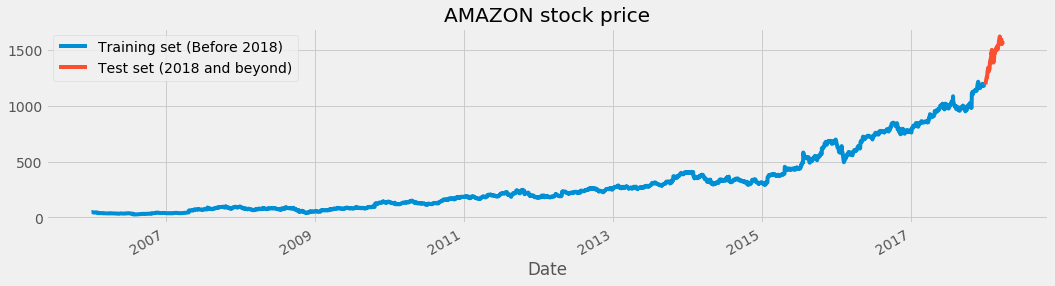

In [111]:
amz["High"][:'2017'].plot(figsize=(16,4),legend=True)
amz["High"]['2018':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2018)','Test set (2018 and beyond)'])
plt.title('AMAZON stock price')
plt.show()

In [112]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [113]:
X_train = []
y_train = []
for i in range(60,2768):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [114]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [115]:
# The LSTM architecture
regressorLG = Sequential()
# First LSTM layer with Dropout regularisation
regressorLG.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressorLG.add(Dropout(0.2))
regressorLG.add(GRU(units=50, activation='tanh'))
regressorLG.add(Dropout(0.2))
# The output layer
regressorLG.add(Dense(units=1))
# Compiling the RNN
regressorLG.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorLG.fit(X_train,y_train,epochs=5,batch_size=150)

Epoch 1/5
2708/2708 [==============================] - 4s 2ms/step - loss: 0.0693
Epoch 2/5
2708/2708 [==============================] - 2s 728us/step - loss: 0.0192
Epoch 3/5
2708/2708 [==============================] - 2s 749us/step - loss: 0.0035
Epoch 4/5
2708/2708 [==============================] - 2s 757us/step - loss: 0.0022
Epoch 5/5
2708/2708 [==============================] - 2s 730us/step - loss: 0.0022


In [116]:
dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2018':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [122]:
len(inputs)

119

In [124]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,119):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
LG_predicted_stock_price = regressorLG.predict(X_test)
LG_predicted_stock_price = sc.inverse_transform(LG_predicted_stock_price)

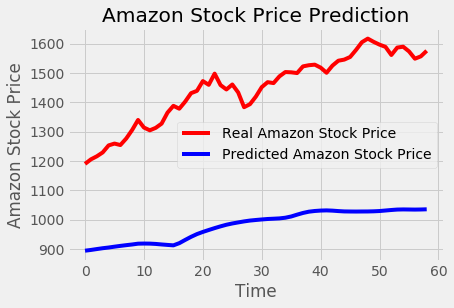

In [125]:
# Visualizing the results for GRU
plot_predictions(test_set,LG_predicted_stock_price)